## Data Loading
### 僅顯示部分

In [1]:
from finlab.data import Data

data = Data()

rev = data.get("當月營收")
ly_rev = data.get("去年同月增減(%)")
begin = data.get("開盤價")
close = data.get("收盤價")

In [2]:
import pandas as pd
print(pd.__version__)

1.5.3


## Features
### 僅顯示部分

In [3]:
import numpy as np
import pandas as pd
def amp(n):
    return (close - begin.shift(n)) / begin.shift(n)
def MACD(n):
    ema12 = close.ewm(span = 12).mean()
    ema26 = close.ewm(span = 26).mean()
    MACD = ema12 - ema26
    signal = MACD.ewm(span = n).mean()
    return MACD - signal
def high(n):
    return high_.rolling(n, min_periods=1).max() / begin.shift(n)

features = {
    'ly_rev': ly_rev/100,
    
    'amp0': amp(0),
    'amp3': amp(3),
    'amp5': amp(5),
    'amp7': amp(7),
    'amp10': amp(10),
    'amp20': amp(20),
    'amp60': amp(60),
    'amp120': amp(120),
    'amp180': amp(180),
    'amp240': amp(240),
    
    'MACD': MACD(9),
    
    'high10': high(10),
}


## Trading Frequency

In [4]:
every_month = close.index[::10]
every_month

DatetimeIndex(['2007-04-23', '2007-05-08', '2007-05-22', '2007-06-05',
               '2007-06-21', '2007-07-04', '2007-07-18', '2007-08-01',
               '2007-08-15', '2007-08-29',
               ...
               '2023-08-30', '2023-09-13', '2023-09-27', '2023-10-16',
               '2023-10-30', '2023-11-13', '2023-11-27', '2023-12-11',
               '2023-12-25', '2024-01-09'],
              dtype='datetime64[ns]', name='date', length=413, freq=None)

## DF merge

In [5]:
for name, f in features.items():
    features[name] = f.reindex(every_month, method='ffill')

In [6]:
for name, f in features.items():
    features[name] = f.unstack()

In [7]:
dataset = pd.DataFrame(features)

In [8]:
feature_names = list(dataset.columns)

## Labeling

### Return & Return ranking cal

In [ ]:
dates = sorted(list(set(dataset.reset_index()['date'])))

tomorrow_begin = tomorrow_begin.shift(-1)
tomorrow_begin = tomorrow_begin.reindex(dates, method='bfill')   

p1 = (tomorrow_adj_open.shift(-n) / tomorrow_adj_open).rank(axis=1, pct=True)
p2 = (tomorrow_adj_open.shift(-n) / tomorrow_adj_open)

dataset['rank'] = p1.unstack()
dataset['return'] = p.unstack()

dataset['10high'] = dataset['high10']

### Extremum & NaN delete

In [ ]:
def drop_extreme_case(dataset, feature_names, thresh=0.001):
    
    extreme_cases = pd.Series(False, index=dataset.index)
    for f in feature_names:
        tf = dataset[f]
        extreme_cases = extreme_cases | (tf < tf.quantile(thresh)) | (tf > tf.quantile(1-thresh))
    dataset = dataset[~extreme_cases]
    return dataset

dataset_drop_extreme_case = drop_extreme_case(dataset, feature_names, thresh=0.01)
print(dataset.shape, dataset_drop_extreme_case.shape)

In [ ]:
dataset_dropna = dataset_drop_extreme_case.dropna(how='any')
dataset_dropna = dataset_dropna.reset_index().set_index("date")
print(dataset_dropna.shape)

In [ ]:
dataset_drop_extreme_case.index.get_level_values("date")

In [ ]:
dataset_train = dataset_dropna.loc[:'2015']
dataset_test = dataset_dropna.loc['2016':]

## NN model
### 簡易模型

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
                
import numpy as np
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint

class SaveTopThreeModels(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.top_models = []

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('val_loss')
        if current_loss is None:
            return

        if len(self.top_models) < 3:
            self.top_models.append((current_loss, epoch, self.model.get_weights()))
            self.top_models = sorted(self.top_models, key=lambda x: x[0])
        else:
            if current_loss < self.top_models[-1][0]:
                self.top_models[-1] = (current_loss, epoch, self.model.get_weights())
                self.top_models = sorted(self.top_models, key=lambda x: x[0])
        
        for i, model in enumerate(self.top_models[:3]): ### only save the top 3 models
            model_path = f'lastbest{i + 1}.mdl'
            self.model.set_weights(model[2])
            self.model.save_weights(model_path, overwrite=True)



In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers 
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LeakyReLU
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os 
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
import optuna
from sklearn.model_selection import train_test_split

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print(len(feature_names))
model = keras.models.Sequential()
model.add(layers.Dense(64, activation='linear', input_shape=(len(feature_names),),
                       kernel_initializer=initializers.he_normal(seed=0)))
model.add(layers.Dense(64, activation='linear',
                      kernel_initializer=initializers.he_normal(seed=0)))
model.add(layers.Dense(64, activation='linear',
                      kernel_initializer=initializers.he_normal(seed=0)))
model.add(layers.Dense(1))
model.summary()

model.compile(loss=Huber(delta=1), optimizer=Adam(learning_rate=0.0005), metrics=[MeanAbsoluteError(), RootMeanSquaredError()])


print('start training')

reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.5, patience=50, min_lr=0.000001)

early_stopping = EarlyStopping(monitor='val_mean_absolute_error',patience=50, restore_best_weights=True)

K.clear_session()
history = model.fit(dataset_train[feature_names], dataset_train['rank'], 
                    batch_size=50, 
                    epochs=8000, verbose=2, 
                    validation_split=0.1, callbacks=[reduce_lr, SaveTopThreeModels(), early_stopping])

### 結果

In [ ]:
from keras.models import load_model
%matplotlib inline
import matplotlib.pyplot as plt

### loading weight
model.load_weights("lastbest1.mdl")

### loss func
plt.figure(figsize=(15, 8)) 
plt.plot(history.history['loss'][1:], label='Training Loss')
plt.plot(history.history['val_loss'][1:], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.show()

In [ ]:
%matplotlib inline      
import matplotlib.pyplot as plt

### MAE
plt.figure(figsize=(15, 8)) 
plt.plot(history.history['mean_absolute_error'][1:], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'][1:], label='Validation MAE')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('Training and Validation MAE over Epochs')
plt.show()


In [ ]:
%matplotlib inline      
import matplotlib.pyplot as plt

### RMSE
plt.figure(figsize=(15, 8)) 
plt.plot(history.history['root_mean_squared_error'][1:], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'][1:], label='Validation RMSE')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Root Mean Squared Error')
plt.title('Training and Validation RMSE over Epochs')
plt.show()


## LightGBM model

In [ ]:
params = {
    'boosting_type': 'gbdt', 
    'objective': 'regression', 

    'learning_rate': 0.005, 
    'n_estimators': 2958,
    'num_leaves': 31, 
    'max_depth': 6,
    'min_data_in_leaf': 20,

    'subsample': 1, 
    'colsample_bytree': 0.7, 
    'reg_alpha': 0.5,
    'reg_lambda': 0.001,
    'feature_fraction': 0.62, 
    'bagging_fraction': 0.1
    }
import lightgbm as lgb
cf = lgb.LGBMRegressor(**params)
cf.fit(dataset_train[feature_names].astype(float), dataset_train['rank'])


## Random Forest model

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

cf2 = RandomForestRegressor(n_estimators=300, n_jobs=-1, oob_score=True,
                            max_features="sqrt")
cf2.fit(dataset_train[feature_names].astype('float64'), dataset_train['rank'])

In [ ]:
feature_imp = pd.DataFrame(zip(cf.feature_importances_, feature_names), 
                           columns=['Value','Feature']).sort_values('Value', ascending=False)
feature_imp

%matplotlib inline
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp)
plt.title('Feature Importance Plot for LightGBM Model', fontsize=16)
plt.show()

## Ensemble learning

In [ ]:
dataset_drop = dataset.dropna(subset=feature_names+['return'])

model.load_weights("lastbest1.mdl")
vals = (model.predict(dataset_drop[feature_names].astype(float)))
dataset_drop['result1'] = pd.Series(vals.swapaxes(0,1)[0], dataset_drop.index)


vals = (cf.predict(dataset_drop[feature_names].astype(float)))
dataset_drop['result2'] = pd.Series(vals, dataset_drop.index)

vals = (cf2.predict(dataset_drop[feature_names].astype('float64')))
dataset_drop['result3'] = pd.Series(vals, dataset_drop.index)

dataset_drop = dataset_drop.reset_index().set_index("date")




## Backtest

In [ ]:
import math
import numpy as np
stock_num = 3

dates = sorted(list(set(dataset_drop.index)))

rs = []
for d in dates:
    
    dataset_time = dataset_drop.loc[d]
    
    dataset_time = drop_extreme_case(dataset_time, features, thresh=0.01)
    rank = dataset_time['result1'] # + dataset_time['result2']+ dataset_time['result3']
    condition = (rank >= rank.nlargest(stock_num).iloc[-1])
    weights = rank[condition]/np.sum(rank[condition])
    mask = (dataset_time['10high'] > 1.25) & condition
    filtered_10high = dataset_time.loc[mask, ['10high','return']]
    if not filtered_10high.empty:
        print(filtered_10high)
    r = np.sum((dataset_time['return'][condition]*weights))
    rs.append(r * (1-3/1000-1.425/1000*2*0.28))

rs = pd.Series(rs, index=dates)['2016':].cumprod()

s0050 = data.get("收盤價")['0050']['2016':]
pd.DataFrame({'nn strategy return':rs.reindex(s0050.index, method='ffill'), '0050 return':s0050/s0050[0]}).plot()

### def backtest

In [ ]:
import math
import pandas as pd
import numpy as np

def strategy_with_stock_num(stock_num):
    dates = sorted(list(set(dataset_drop.index)))
    rs = []
    rs1 = []
    rs2 = []
    rs3 = []
    rs4 = []
    r_rs = []
    
    dataset_drop['return_r'] = dataset_drop['return']
    dataset_drop['return1'] = dataset_drop['return']
    dataset_drop['return2'] = dataset_drop['return']
    dataset_drop['return3'] = dataset_drop['return']
    dataset_drop['return4'] = dataset_drop['return']
    for d in dates:
        dataset_time = dataset_drop.loc[d]
        dataset_time = drop_extreme_case(dataset_time,features, thresh=0.01) 
        
        rank = dataset_time['result1'] + dataset_time['result2']+ dataset_time['result3']
        rank1 = dataset_time['result1']
        rank2 = dataset_time['result2']
        rank3 = dataset_time['result3']
        rank4 = dataset_time['result1'] + dataset_time['result2']

        def condition_(rank):
            return rank >= rank.nlargest(stock_num).iloc[-1]
        
        condition = condition_(rank)
        condition1 = condition_(rank1)
        condition2 = condition_(rank2)
        condition3 = condition_(rank3)
        condition4 = condition_(rank4)
        condition_random = (dataset_time.sample(n=stock_num, replace=True)) 
        
        weights = rank[condition]/np.sum(rank[condition])
        weights1 = rank1[condition1]/np.sum(rank1[condition1])
        weights2 = rank2[condition2]/np.sum(rank2[condition2])
        weights3 = rank3[condition3]/np.sum(rank3[condition3])
        weights4 = rank4[condition4]/np.sum(rank4[condition4])
        
        mask = (dataset_time['10high'] > 1.25) 
        mask1 = (dataset_time['10high'] > 1.25)
        mask2 = (dataset_time['10high'] > 1.25)
        mask3 = (dataset_time['10high'] > 1.25)
        mask4 = (dataset_time['10high'] > 1.25)
        
        dataset_time.loc[mask, 'return_r'] = 1.25
        dataset_time.loc[mask1, 'return1'] = 1.25
        dataset_time.loc[mask2, 'return2'] = 1.25
        dataset_time.loc[mask3, 'return3'] = 1.25
        dataset_time.loc[mask4, 'return4'] = 1.25
        
        r = np.sum((dataset_time['return_r'][condition]*weights))
        r1 = np.sum((dataset_time['return1'][condition1]*weights1))
        r2 = np.sum((dataset_time['return2'][condition2]*weights2))
        r3 = np.sum((dataset_time['return3'][condition3]*weights3))
        r4 = np.sum((dataset_time['return4'][condition4]*weights4))
        r_r = condition_random['return'].mean()
            
        rs.append(float((r)) * (1-3/1000-1.425/1000*2*0.28))
        rs1.append(float((r1))* (1-3/1000-1.425/1000*2*0.28))
        rs2.append(float((r2)) * (1-3/1000-1.425/1000*2*0.28))
        rs3.append(float((r3)) * (1-3/1000-1.425/1000*2*0.28))
        rs4.append(float((r4)) * (1-3/1000-1.425/1000*2*0.28))
        r_rs.append(math.floor(r_r * (1-3/1000-1.425/1000*2*0.28) *10000) / 10000)
    
    rs = pd.Series(rs, index=dates)['2016':].cumprod()
    rs1 = pd.Series(rs1, index=dates)['2016':].cumprod()
    rs2 = pd.Series(rs2, index=dates)['2016':].cumprod()
    rs3 = pd.Series(rs3, index=dates)['2016':].cumprod()
    rs4 = pd.Series(rs4, index=dates)['2016':].cumprod()
    r_rs = pd.Series(r_rs, index=dates)['2016':].cumprod()

    def win_rate(rs):
        win = 0
        count = -1
        loss_per = 1
        gain_per = 0
        for r in rs:
            if count == -1:
                count = -1
            else :
                if (r/rs[count] > 1):
                    win += 1
                    if (r/rs[count]>gain_per):
                        gain_per = r/rs[count]
                elif (r/rs[count]<loss_per):
                    loss_per = r/rs[count]
                
            count = count + 1
        return('win_rate:{0:.2%},max_drop:{1:.2%},max_gain:{2:.2%}'.format(win/rs.size,1-loss_per,gain_per-1))
    
    pdtitle = 'trade per 10 days, stock_num =' + str(stock_num)
    s0050 = data.get("收盤價")['0050']['2016':]
    pd.DataFrame({'strategy            '+str(win_rate(rs)):rs.reindex(s0050.index, method='ffill'),
                  'strategy without rf '+str(win_rate(rs4)):rs4.reindex(s0050.index, method='ffill'),
                  'nn strategy         '+str(win_rate(rs1)):rs1.reindex(s0050.index, method='ffill'),
                  'lgb strategy        '+str(win_rate(rs2)):rs2.reindex(s0050.index, method='ffill'),
                  'rf strategy         '+str(win_rate(rs3)):rs3.reindex(s0050.index, method='ffill'),
                  #'random strategy     '+str(win_rate(r_rs)):r_rs.reindex(s0050.index, method='ffill'),
                  #'0050 return':s0050/s0050[0]})
                 }).plot(figsize=(15,10), title=pdtitle)
    return(rs,rs4,rs1,rs2,rs3)


#### backtest

/home/stock/Desktop/stock/finlab/data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  all_index = (df.index | item.index).sort_values()
/home/stock/Desktop/stock/finlab/data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  all_index = (df.index | item.index).sort_values()
/home/stock/Desktop/stock/finlab/data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  all_index = (df.index | item.index).sort_values()
/home/stock/Desktop/stock/finlab/data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Seri

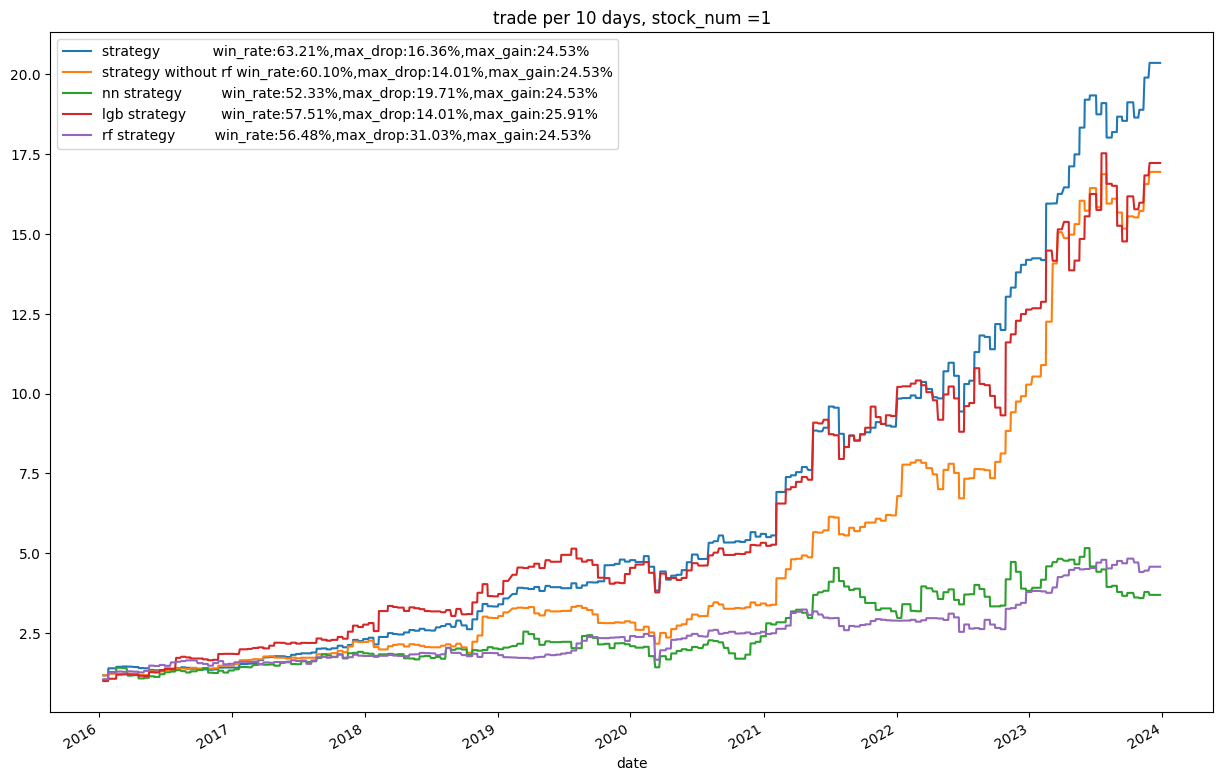

In [1209]:
rs,rs4,rs1,rs2,rs3 = strategy_with_stock_num(1)

/home/stock/Desktop/stock/finlab/data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  all_index = (df.index | item.index).sort_values()
/home/stock/Desktop/stock/finlab/data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  all_index = (df.index | item.index).sort_values()
/home/stock/Desktop/stock/finlab/data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  all_index = (df.index | item.index).sort_values()
/home/stock/Desktop/stock/finlab/data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Seri

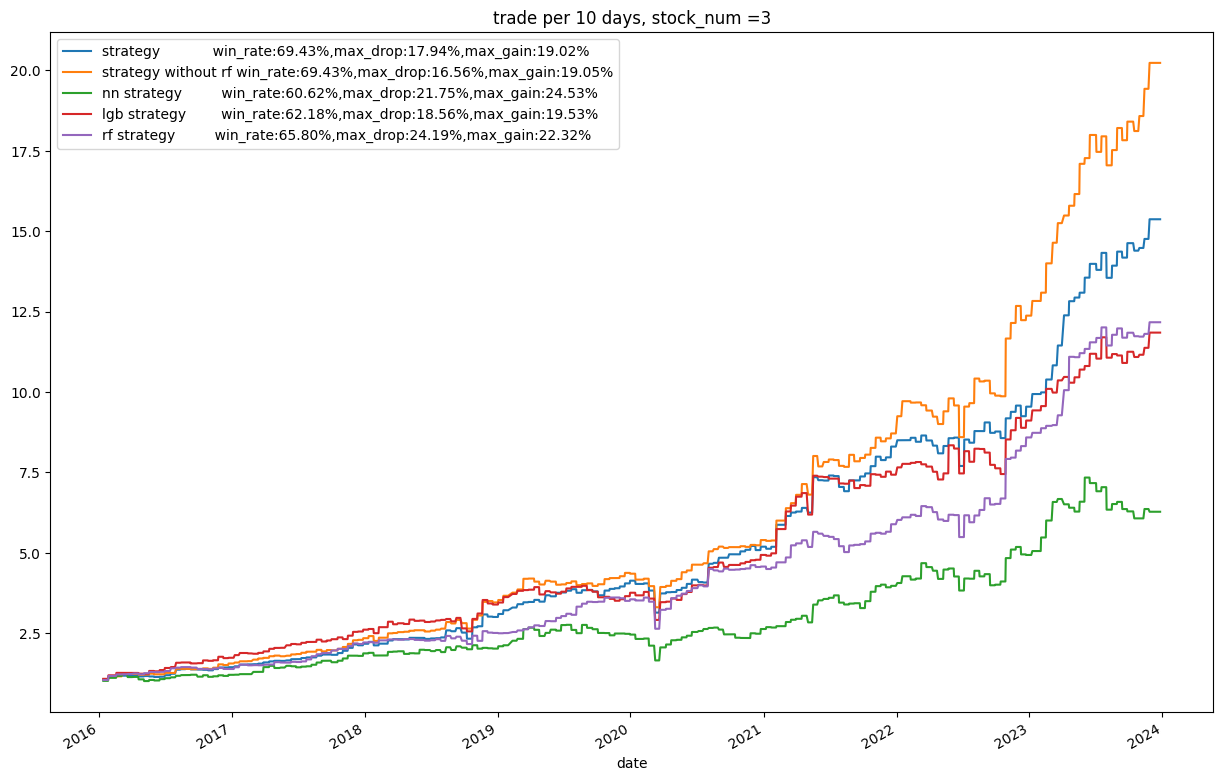

In [1210]:
rs,rs4,rs1,rs2,rs3 = strategy_with_stock_num(3)

In [1211]:
yearly_resampled_rs = rs.resample('Y')
yearly_resampled_rs4 = rs4.resample('Y')

first_value_rs = yearly_resampled_rs.first()
last_value_rs = yearly_resampled_rs.last()
first_value_rs4 = yearly_resampled_rs4.first()
last_value_rs4 = yearly_resampled_rs4.last()

yearly_returns_rs = (last_value_rs - first_value_rs) / first_value_rs * 100
yearly_returns_rs4 = (last_value_rs4 - first_value_rs4) / first_value_rs4 * 100

print("Yearly Returns for rs1:")
print(yearly_returns_rs)
print("\nYearly Returns for rs4:")
print(yearly_returns_rs4)
#rs,rs4

Yearly Returns for rs1:
2016-12-31    34.977554
2017-12-31    47.773820
2018-12-31    34.727959
2019-12-31    33.435668
2020-12-31    28.738480
2021-12-31    61.979304
2022-12-31    12.295993
2023-12-31    54.698848
Freq: A-DEC, dtype: float64

Yearly Returns for rs4:
2016-12-31    46.991395
2017-12-31    47.727940
2018-12-31    43.448760
2019-12-31    23.173476
2020-12-31    29.530315
2021-12-31    62.213408
2022-12-31    33.828904
2023-12-31    57.700570
Freq: A-DEC, dtype: float64


/home/stock/Desktop/stock/finlab/data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  all_index = (df.index | item.index).sort_values()
/home/stock/Desktop/stock/finlab/data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  all_index = (df.index | item.index).sort_values()
/home/stock/Desktop/stock/finlab/data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  all_index = (df.index | item.index).sort_values()
/home/stock/Desktop/stock/finlab/data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Seri

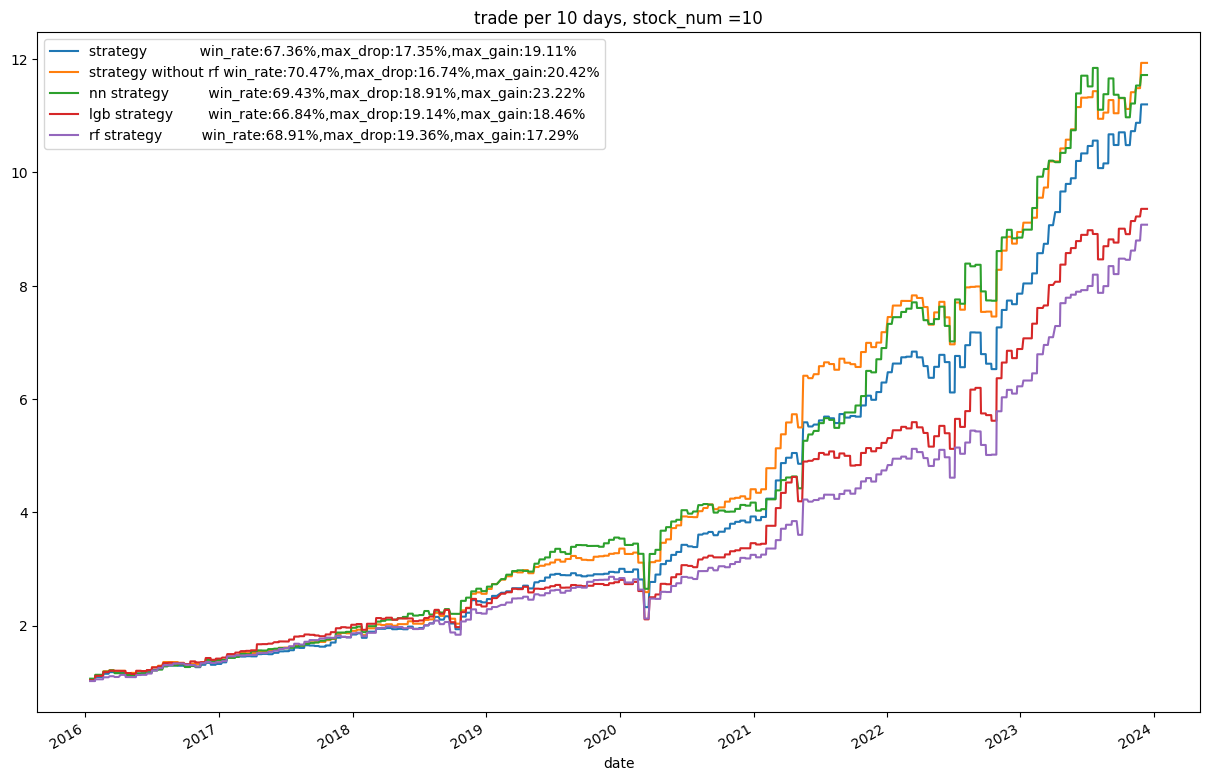

In [52]:
rs,rs4,rs1,rs2,rs3 = strategy_with_stock_num(10)

/home/stock/Desktop/stock/finlab/data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  all_index = (df.index | item.index).sort_values()
/home/stock/Desktop/stock/finlab/data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  all_index = (df.index | item.index).sort_values()
/home/stock/Desktop/stock/finlab/data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  all_index = (df.index | item.index).sort_values()
/home/stock/Desktop/stock/finlab/data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Seri

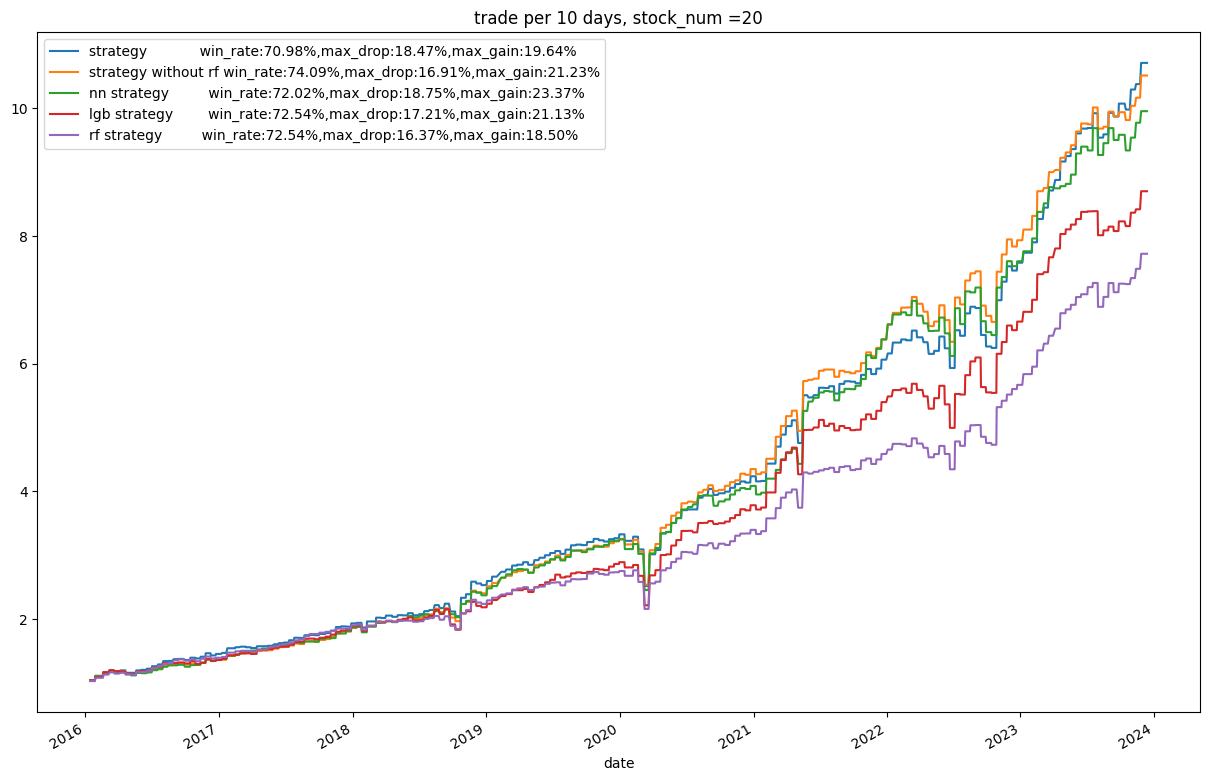

In [53]:
rs,rs4,rs1,rs2,rs3 = strategy_with_stock_num(20)

/home/stock/Desktop/stock/finlab/data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  all_index = (df.index | item.index).sort_values()
/home/stock/Desktop/stock/finlab/data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  all_index = (df.index | item.index).sort_values()
/home/stock/Desktop/stock/finlab/data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  all_index = (df.index | item.index).sort_values()
/home/stock/Desktop/stock/finlab/data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Seri

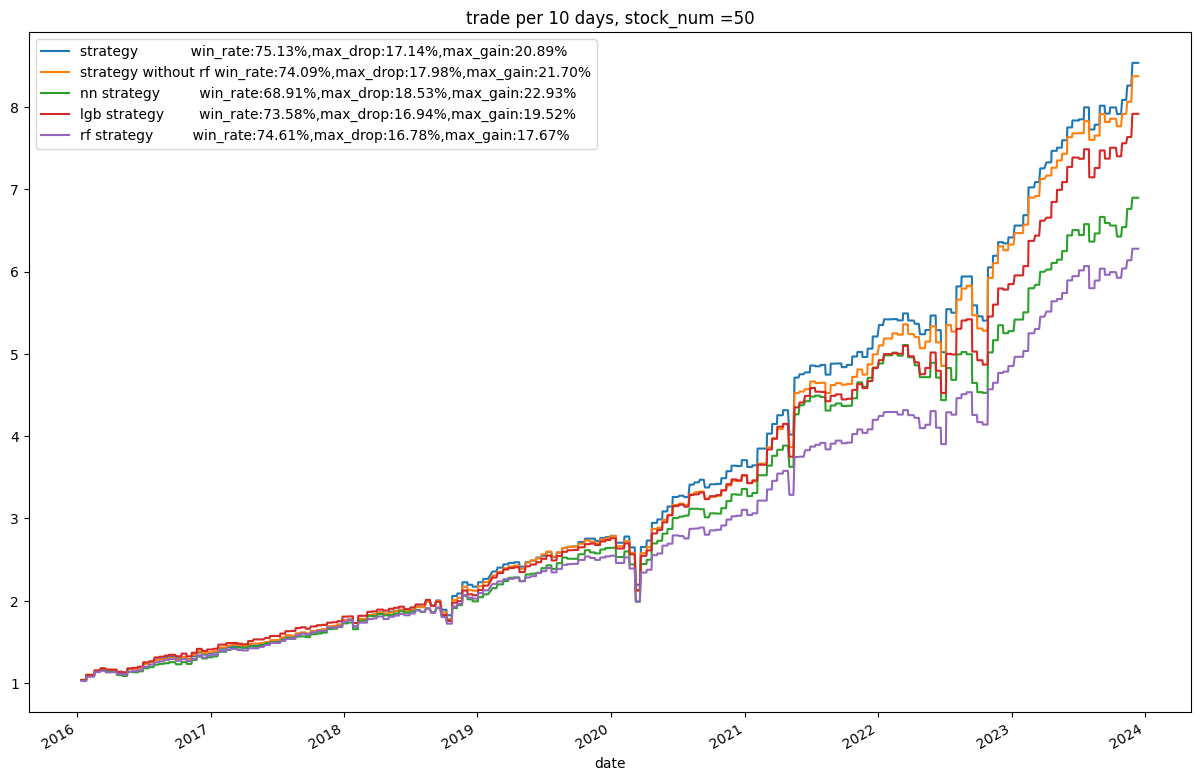

In [54]:
rs,rs4,rs1,rs2,rs3 = strategy_with_stock_num(50)

In [ ]:
dataset.index.levels[1]

## 當期預測

In [ ]:
last_date = dataset.index.levels[1].max()
print(last_date)
is_last_date = dataset.index.get_level_values('date') == last_date
last_dataset = dataset[is_last_date].copy()


last_dataset = drop_extreme_case(last_dataset,features, thresh=0.01) 

last_dataset = last_dataset.dropna(subset=feature_names)
vals = model.predict(last_dataset[feature_names].values)
last_dataset['result1'] = pd.Series(vals.swapaxes(0,1)[0], last_dataset.index)


vals = cf.predict(last_dataset[feature_names].astype(float))
last_dataset['result2'] = pd.Series(vals, last_dataset.index)


rank = last_dataset['result1'] + last_dataset['result2']
condition = (rank >= rank.nlargest(10).iloc[-1]) 

rank.hist(bins=100)

slist1 = rank[condition].reset_index()['stock_id']
slist1 

In [ ]:
dataset.index.levels[-1]

## 碩論圖資產製

/home/stock/Desktop/stock/finlab/data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  all_index = (df.index | item.index).sort_values()
/home/stock/Desktop/stock/finlab/data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  all_index = (df.index | item.index).sort_values()
/home/stock/Desktop/stock/finlab/data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  all_index = (df.index | item.index).sort_values()
/home/stock/Desktop/stock/finlab/data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Seri

<Axes: title={'center': 'trade per 10 days, stock_num =3'}, xlabel='date'>

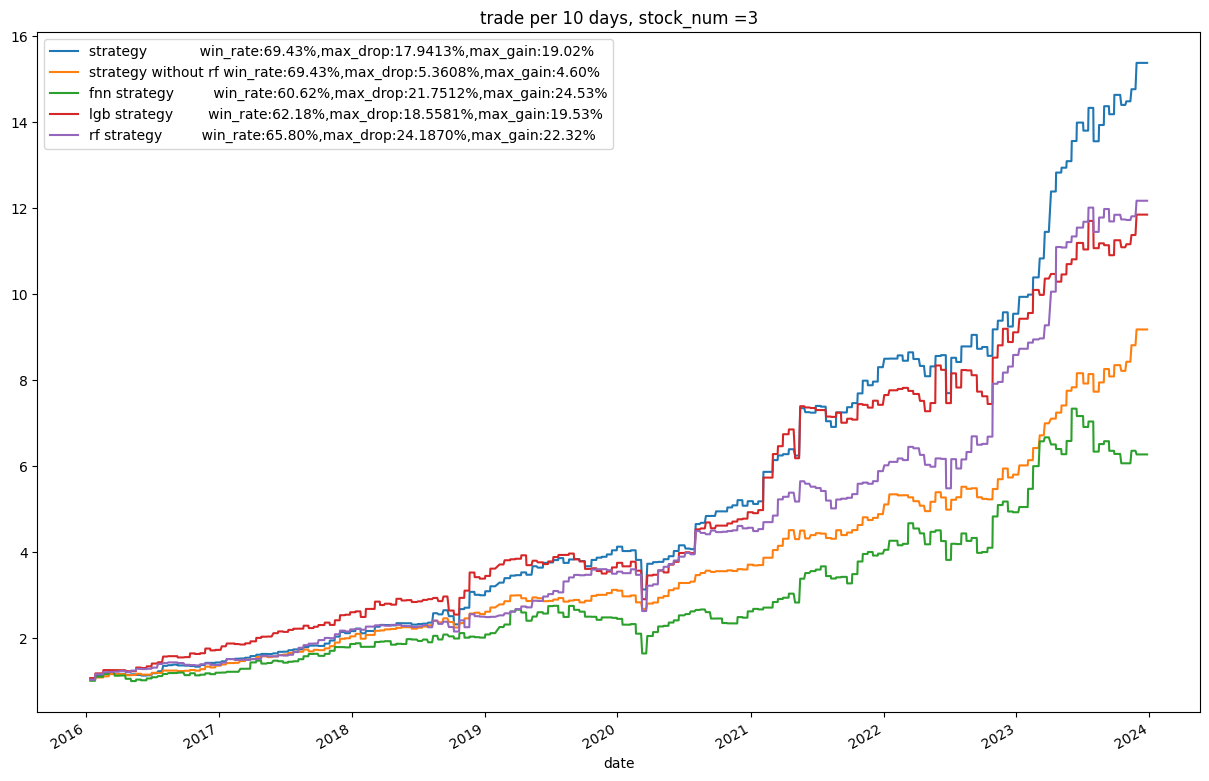

In [1224]:
stock_num = 3
dates = sorted(list(set(dataset_drop.index)))
rs = []
rs1 = []
rs2 = []
rs3 = []
rs4 = []
r_rs = []


rs_list_ = []
rs1_list_ = []
rs2_list_ = []
rs3_list_ = []
rs4_list_ = []


dataset_drop['return_r'] = dataset_drop['return']
dataset_drop['return1'] = dataset_drop['return']
dataset_drop['return2'] = dataset_drop['return']
dataset_drop['return3'] = dataset_drop['return']
dataset_drop['return4'] = dataset_drop['return']
for d in dates:
    dataset_time = dataset_drop.loc[d]
    dataset_time = drop_extreme_case(dataset_time,features, thresh=0.01) 

    rank = dataset_time['result1'] + dataset_time['result2']+ dataset_time['result3']
    rank1 = dataset_time['result1']
    rank2 = dataset_time['result2']
    rank3 = dataset_time['result3']
    rank4 = dataset_time['result1'] + dataset_time['result2']

    def condition_(rank):
        return rank >= rank.nlargest(stock_num).iloc[-1]

    condition = condition_(rank)
    condition1 = condition_(rank1)
    condition2 = condition_(rank2)
    condition3 = condition_(rank3)
    condition4 = condition_(rank4)
    condition_random = (dataset_time.sample(n=stock_num, replace=True)) 

    weights = rank[condition]/np.sum(rank[condition])
    weights1 = rank1[condition1]/np.sum(rank1[condition1])
    weights2 = rank2[condition2]/np.sum(rank2[condition2])
    weights3 = rank3[condition3]/np.sum(rank3[condition3])
    weights4 = rank4[condition4]/np.sum(rank4[condition4])

    mask = (dataset_time['10high'] > 1.25) #& (dataset_time['10high'] > dataset_time['return'])
    mask1 = (dataset_time['10high'] > 1.25) #& (dataset_time['10high'] > dataset_time['return'])
    mask2 = (dataset_time['10high'] > 1.25) #& (dataset_time['10high'] > dataset_time['return'])
    mask3 = (dataset_time['10high'] > 1.25) #& (dataset_time['10high'] > dataset_time['return'])
    mask4 = (dataset_time['10high'] > 1.25) #& (dataset_time['10high'] > dataset_time['return'])

    dataset_time.loc[mask, 'return_r'] = 1.25
    dataset_time.loc[mask1, 'return1'] = 1.25
    dataset_time.loc[mask2, 'return2'] = 1.25
    dataset_time.loc[mask3, 'return3'] = 1.25
    dataset_time.loc[mask4, 'return4'] = 1.25

    r = np.sum((dataset_time['return_r'][condition]*weights))
    r1 = np.sum((dataset_time['return1'][condition1]*weights1))
    r2 = np.sum((dataset_time['return2'][condition2]*weights2))
    r3 = np.sum((dataset_time['return3'][condition3]*weights3))
    r4 = np.sum((dataset_time['return4'][condition4]*weights4))
    if (r4<0.95):
        r4 = 0.95
    elif (r4>1.05):
        r4 = 1.05
    r_r = condition_random['return'].mean()
    
    rs_list_.append(float((r)) * (1-3/1000-1.425/1000*2*0.28))
    rs1_list_.append(float((r1)) * (1-3/1000-1.425/1000*2*0.28))
    rs2_list_.append(float((r2)) * (1-3/1000-1.425/1000*2*0.28))
    rs3_list_.append(float((r3)) * (1-3/1000-1.425/1000*2*0.28))
    rs4_list_.append(float((r4)) * (1-3/1000-1.425/1000*2*0.28))
    
    rs.append(float((r)) * (1-3/1000-1.425/1000*2*0.28))
    rs1.append(float((r1))* (1-3/1000-1.425/1000*2*0.28))
    rs2.append(float((r2)) * (1-3/1000-1.425/1000*2*0.28))
    rs3.append(float((r3)) * (1-3/1000-1.425/1000*2*0.28))
    rs4.append(float((r4)) * (1-3/1000-1.425/1000*2*0.28))
    r_rs.append(math.floor(r_r * (1-3/1000-1.425/1000*2*0.28) *10000) / 10000)

rs_list_ = pd.Series(rs_list_, index=dates)['2016':]
rs1_list_ = pd.Series(rs1_list_, index=dates)['2016':]
rs2_list_ = pd.Series(rs2_list_, index=dates)['2016':]
rs3_list_ = pd.Series(rs3_list_, index=dates)['2016':]
rs4_list_ = pd.Series(rs4_list_, index=dates)['2016':]

rs = pd.Series(rs, index=dates)['2016':].cumprod()
rs1 = pd.Series(rs1, index=dates)['2016':].cumprod()
rs2 = pd.Series(rs2, index=dates)['2016':].cumprod()
rs3 = pd.Series(rs3, index=dates)['2016':].cumprod()
rs4 = pd.Series(rs4, index=dates)['2016':].cumprod()
r_rs = pd.Series(r_rs, index=dates)['2016':].cumprod()


def win_rate(rs):
    win = 0
    count = -1
    loss_per = 1
    gain_per = 0
    for r in rs:
        if count == -1:
            count = -1
        else :
            if (r/rs[count] > 1):
                win += 1
                if (r/rs[count]>gain_per):
                    gain_per = r/rs[count]
            elif (r/rs[count]<loss_per):
                loss_per = r/rs[count]

        count = count + 1
    return('win_rate:{0:.2%},max_drop:{1:.4%},max_gain:{2:.2%}'.format(win/rs.size,1-loss_per,gain_per-1))

pdtitle = 'trade per 10 days, stock_num =' + str(stock_num)
s0050 = data.get_adj("收盤價")['0050']['2016':]
#print(rs4)
pd.DataFrame({'strategy            '+str(win_rate(rs)):rs.reindex(s0050.index, method='ffill'),
              'strategy without rf '+str(win_rate(rs4)):rs4.reindex(s0050.index, method='ffill'),
              'fnn strategy         '+str(win_rate(rs1)):rs1.reindex(s0050.index, method='ffill'),
              'lgb strategy        '+str(win_rate(rs2)):rs2.reindex(s0050.index, method='ffill'),
              'rf strategy         '+str(win_rate(rs3)):rs3.reindex(s0050.index, method='ffill'),
              #'random strategy     '+str(win_rate(r_rs)):r_rs.reindex(s0050.index, method='ffill'),
              #'0050 return':s0050/s0050[0]})
             }).plot(figsize=(15,10), title=pdtitle)

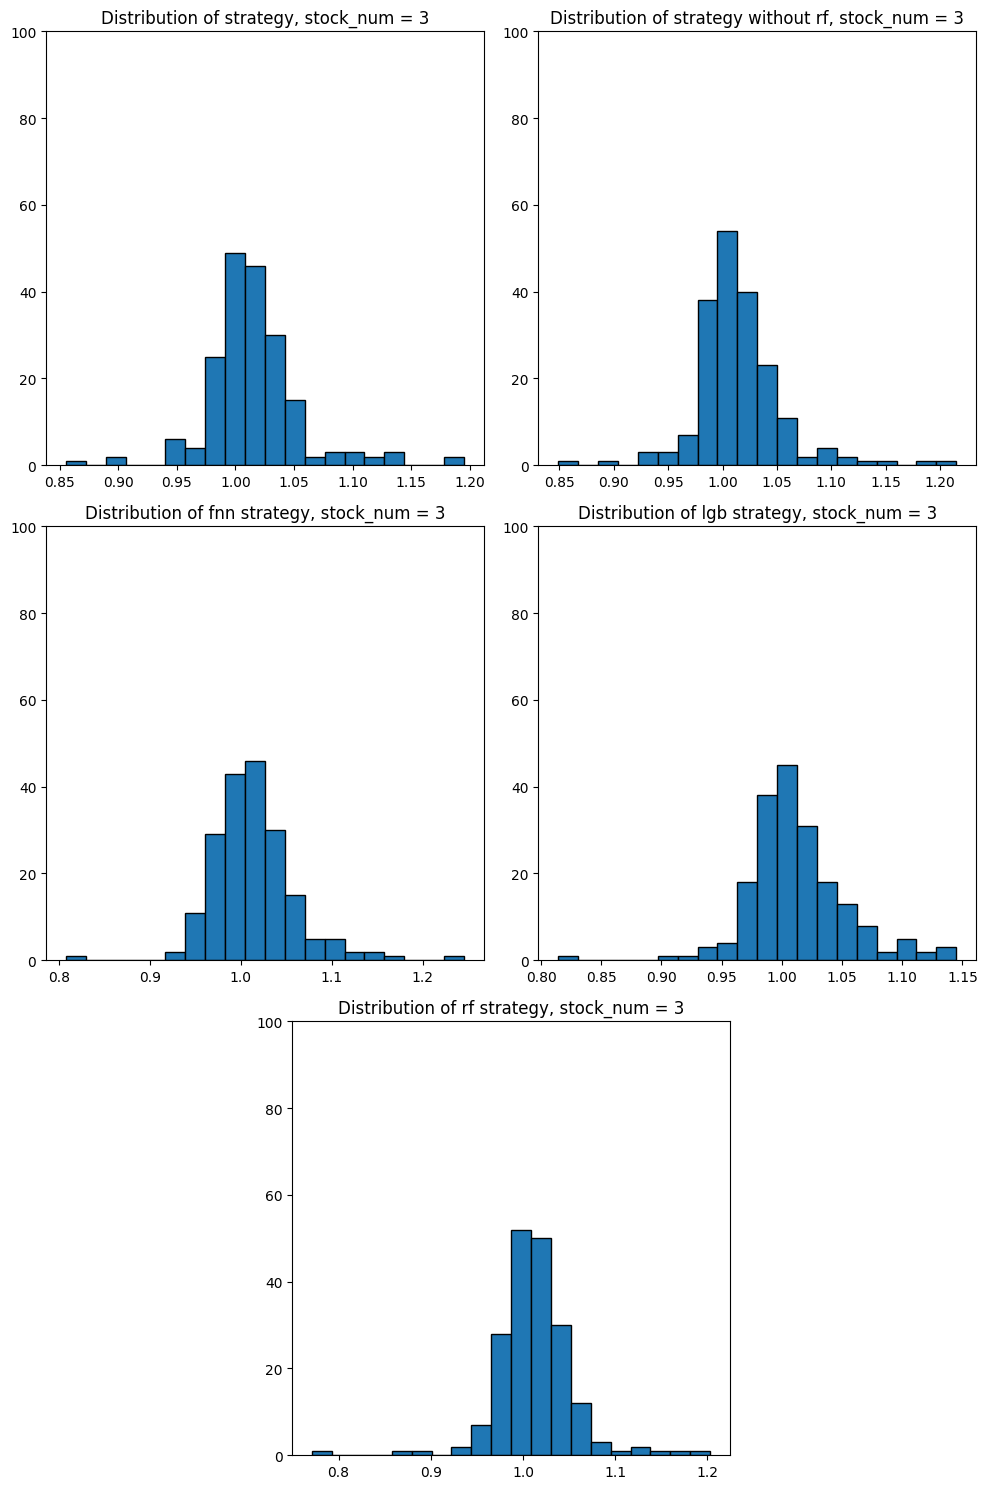

In [1124]:
rs_list = rs_list_.shift(1).resample('M').apply(lambda x: x.cumprod().iloc[-1])
rs1_list = rs1_list_.shift(1).resample('M').apply(lambda x: x.cumprod().iloc[-1])
rs2_list = rs2_list_.shift(1).resample('M').apply(lambda x: x.cumprod().iloc[-1])
rs3_list = rs3_list_.shift(1).resample('M').apply(lambda x: x.cumprod().iloc[-1])
rs4_list = rs4_list_.shift(1).resample('M').apply(lambda x: x.cumprod().iloc[-1])
import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 15))

gs = gridspec.GridSpec(3, 4)

axs1 = fig.add_subplot(gs[0, 0:2])
axs1.hist(rs_list_, bins=20, edgecolor='black')
axs1.set_title('Distribution of strategy, stock_num = ' + str(stock_num))
axs1.set_ylim(0, 100) 

axs2 = fig.add_subplot(gs[0, 2:4])
axs2.hist(rs4_list_, bins=20, edgecolor='black')
axs2.set_title('Distribution of strategy without rf, stock_num = ' + str(stock_num))
axs2.set_ylim(0, 100) 

axs3 = fig.add_subplot(gs[1, 0:2])
axs3.hist(rs1_list_, bins=20, edgecolor='black')
axs3.set_title('Distribution of fnn strategy, stock_num = ' + str(stock_num))
axs3.set_ylim(0, 100) 

axs4 = fig.add_subplot(gs[1, 2:4])
axs4.hist(rs2_list_, bins=20, edgecolor='black')  
axs4.set_title('Distribution of lgb strategy, stock_num = ' + str(stock_num))
axs4.set_ylim(0, 100) 

axs5 = fig.add_subplot(gs[2, 1:3])
axs5.hist(rs3_list_, bins=20, edgecolor='black')  
axs5.set_title('Distribution of rf strategy, stock_num = ' + str(stock_num))
axs5.set_ylim(0, 100) 


plt.tight_layout()

plt.show()


In [1088]:
def sharpe(r_list):
    return round((np.mean(r_list)-1.001295) / np.std(r_list),5)
sharpe(s2412_),stock_num

(0.19507, 50)

In [1099]:
twii = data.get("發行量加權股價指數")['台股指數'].reindex(s0050_.index, method ='ffill')['2016':]
twii = (twii / twii[0])
twii = (twii / twii.shift(1)).fillna(1)
def treynor(r_list):
    X = np.corrcoef(np.array(twii), np.array(r_list))[0,1]
    beta = X * np.std(r_list) / np.std(twii)
    return round(beta,5), round((np.mean(r_list) - 1.001295) / beta,5)

In [1104]:
treynor(s2412_),stock_num

((0.13111, 0.03331), 50)

In [1074]:
#best_50 = rs
#best_3 = rs
#best_10 = rs4

twii = data.get("發行量加權股價指數")['台股指數'].reindex(rs_list.index, method ='ffill')['2016':]
twii= twii / twii.shift(1)
twii.fillna(1)
sharpe(twii),stock_num

(0.1709753, 10)

In [1061]:
twii,s2330_

(date
 2016-01-31    1.000000
 2016-02-29    1.032651
 2016-03-31    1.038744
 2016-04-30    0.958895
 2016-05-31    1.018856
                 ...   
 2023-08-31    0.966859
 2023-09-30    0.978105
 2023-10-31    0.987522
 2023-11-30    1.075598
 2023-12-31    1.005663
 Freq: M, Name: 台股指數, Length: 96, dtype: float64,
 date
 2016-01-31    1.000000
 2016-02-29    1.059649
 2016-03-31    1.072848
 2016-04-30    0.932099
 2016-05-31    1.036424
                 ...   
 2023-08-31    0.961739
 2023-09-30    0.951024
 2023-10-31    1.022945
 2023-11-30    1.076636
 2023-12-31    1.000000
 Freq: M, Name: 2330, Length: 96, dtype: float64)

<Axes: title={'center': 'trade per 10 days'}, xlabel='date'>

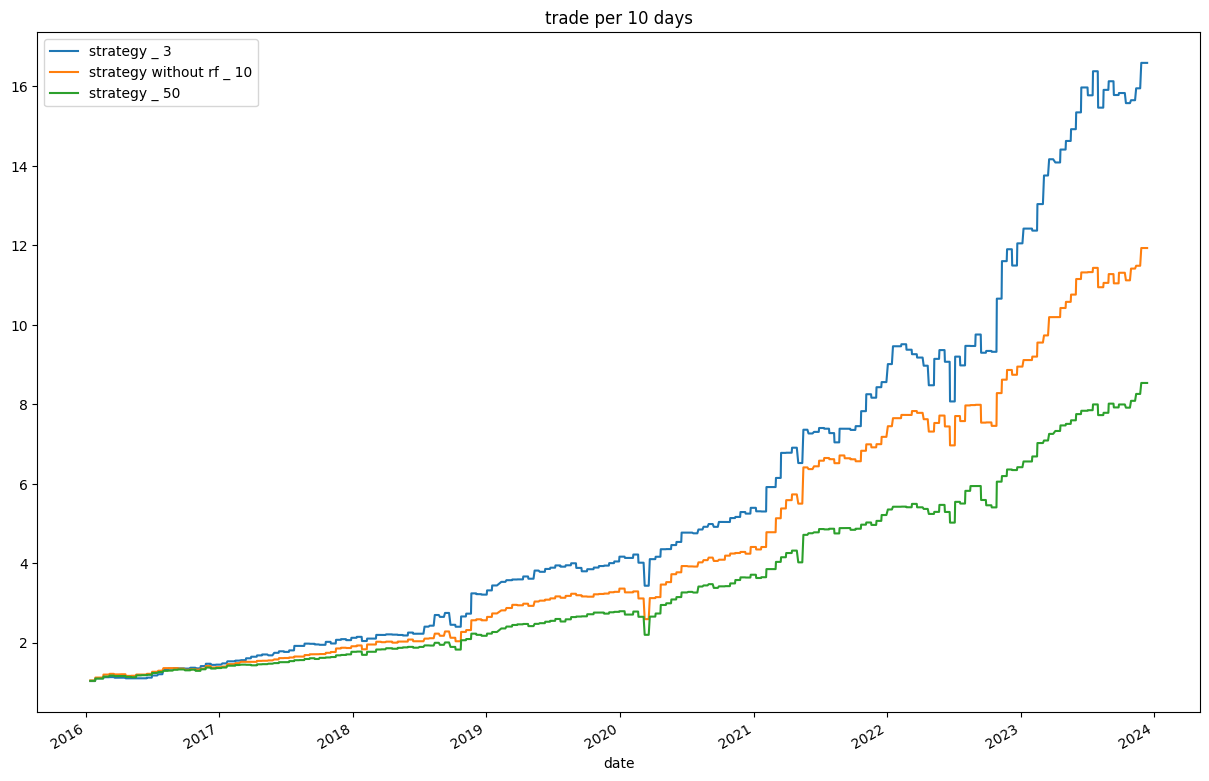

In [781]:
pdtitle = 'trade per 10 days'
pd.DataFrame({'strategy _ 3  ':best_3.reindex(s0050.index, method='ffill'),
              'strategy without rf _ 10':best_10.reindex(s0050.index, method='ffill'),
              'strategy _ 50  ':best_50.reindex(s0050.index, method='ffill'),
              #'random strategy     '+str(win_rate(r_rs)):r_rs.reindex(s0050.index, method='ffill'),
              #'0050 return':s0050/s0050[0]})
             }).plot(figsize=(15,10), title=pdtitle)

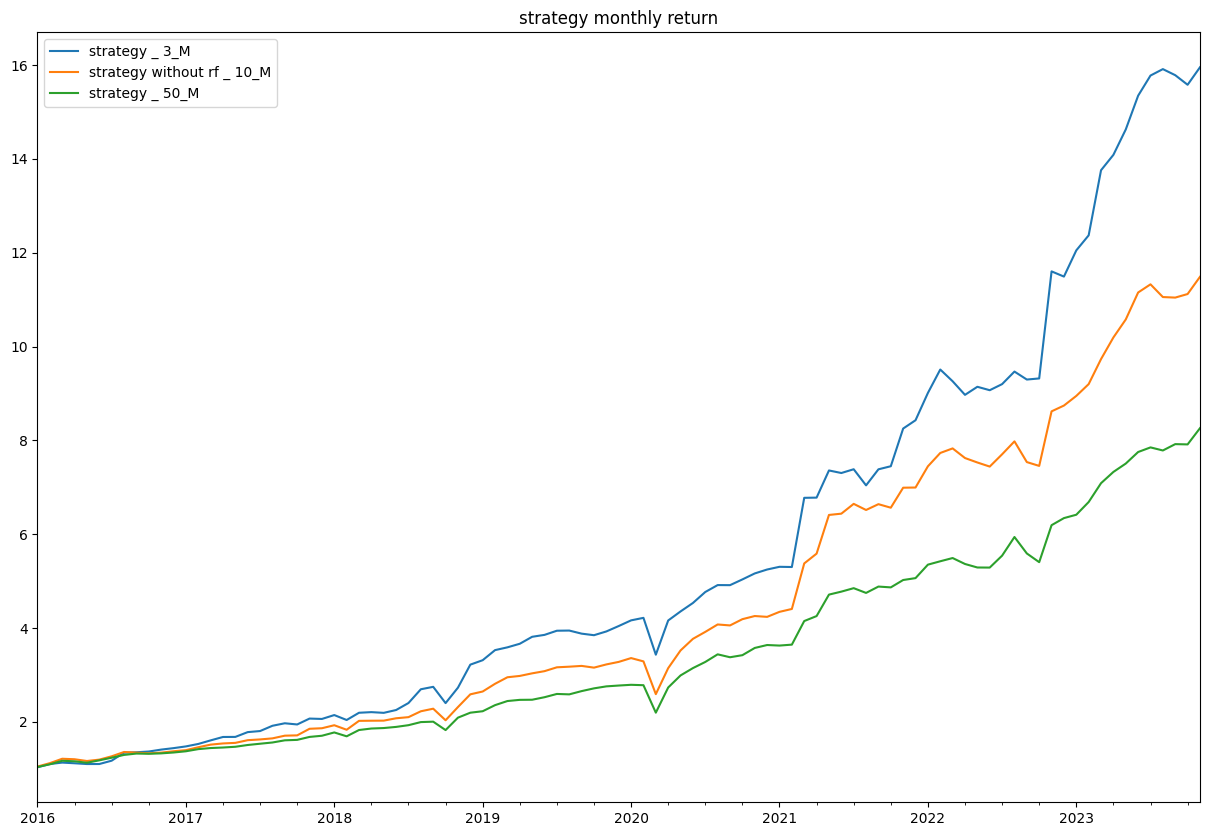

In [805]:
pdtitle = 'strategy monthly return'
fig, ax = plt.subplots(figsize=(15, 10))


pd.DataFrame({'strategy _ 3_M  ':best_3.shift(1)['2016':].resample('M').last(),
              'strategy without rf _ 10_M':best_10.shift(1)['2016':].resample('M').last(),
              'strategy _ 50_M  ':best_50.shift(1)['2016':].resample('M').last(),
             }).plot(ax=ax, figsize=(15, 10),title=pdtitle)
ax.legend()
plt.show()

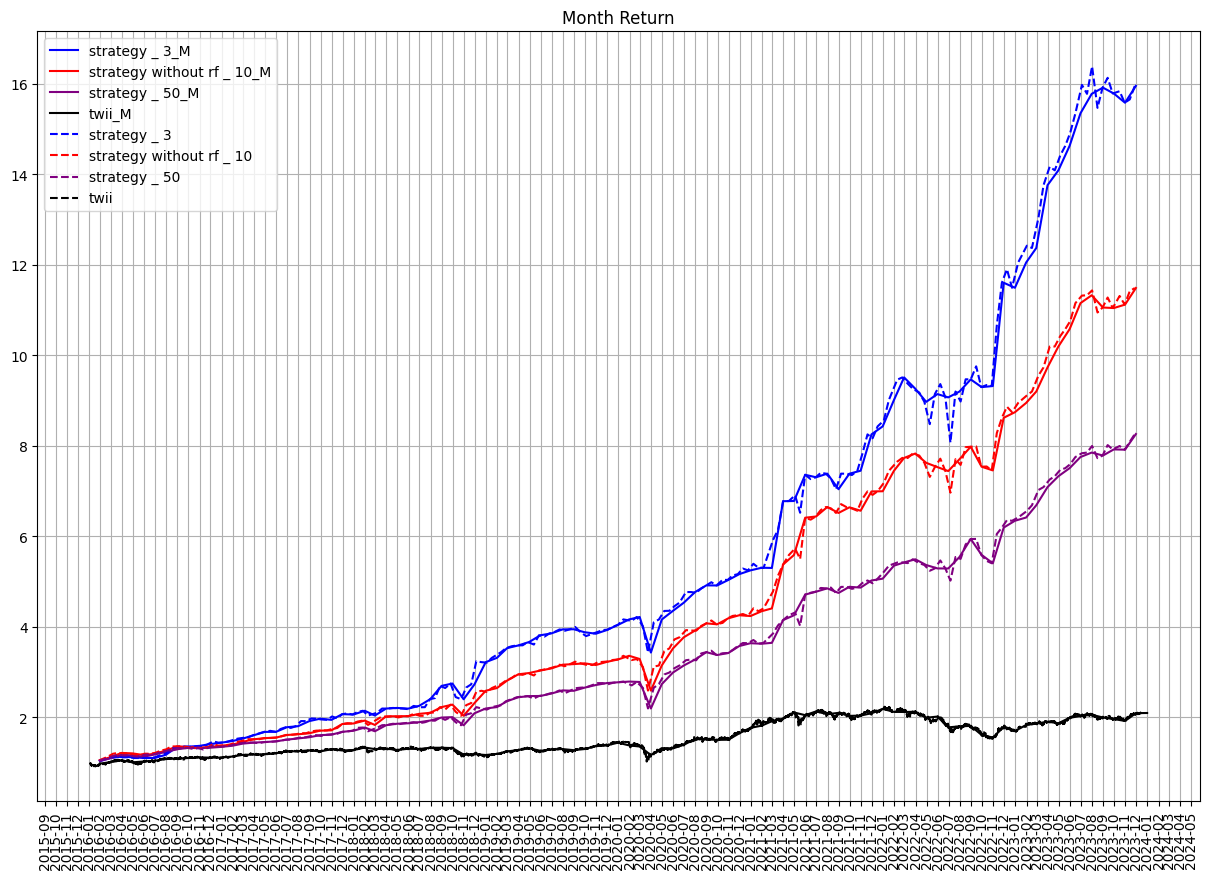

In [818]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax1 = plt.subplots(figsize=(15, 10))
twii_ = data.get("發行量加權股價指數")['台股指數']['2016':]

twii_daily = twii_.resample('D').mean()
twii_daily = (twii_daily/twii_daily[0])

twii_= twii_ / twii_[0]
twii_ = twii_


ax1.plot(best_3.resample('M').last().index, best_3.shift(1).resample('M').last().values, label='strategy _ 3_M',color='blue')
ax1.plot(best_10.resample('M').last().index, best_10.shift(1).resample('M').last().values, label='strategy without rf _ 10_M',color='red')
ax1.plot(best_50.resample('M').last().index, best_50.shift(1).resample('M').last().values, label='strategy _ 50_M',color='purple')
ax1.plot(twii_daily.resample('M').last().shift(0).index, twii_.resample('M').last().shift(0).values, label='twii_M',color='black')


pdtitle = 'Month Return'
ax1.set_title(pdtitle)


ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

ax1.plot(best_3.index, best_3.shift(1).values, label='strategy _ 3',color='blue',linestyle='dashed')
ax1.plot(best_10.index, best_10.shift(1).values, label='strategy without rf _ 10',color='red',linestyle='dashed')
ax1.plot(best_50.index, best_50.shift(1).values, label='strategy _ 50',color='purple',linestyle='dashed')
#ax1.plot((s0050/s0050[0])['2019-08':'2021'].index, (s0050/s0050[0])['2019-08':'2021'].values, label='strategy _ 50',color='purple',linestyle='dashed')
ax1.plot(twii_.index, twii_.values, label='twii',color='black',linestyle='dashed')

ax1.legend(loc='upper left')

plt.xticks(rotation=90)

plt.grid(True)

plt.show()


In [574]:
twii_ = data.get("發行量加權股價指數")['台股指數']['2016':'2022']
twii_= twii_ / twii_[0]
twii_.shift(-)['2019-08']

date
2019-08-01 09:00:00    1.286759
2019-08-01 09:00:05    1.286774
2019-08-01 09:00:10    1.287003
2019-08-01 09:00:15    1.287026
2019-08-01 09:00:20    1.287268
                         ...   
2019-08-30 13:29:40    1.270744
2019-08-30 13:29:45    1.270673
2019-08-30 13:29:50    1.270682
2019-08-30 13:29:55    1.270331
2019-08-30 13:30:00    1.270010
Name: 台股指數, Length: 68061, dtype: float64

In [1156]:
best_3_count = best_50.shift(1).fillna(1)
best_3_count = (best_3_count / best_3_count.shift(1)).fillna(1)

In [1157]:
best_3_count.to_csv('your_file_path.csv', header=True)

In [1182]:
best_50.shift(1).fillna(1)

2016-01-14    1.000000
2016-01-28    1.037258
2016-02-19    1.094639
2016-03-07    1.144226
2016-03-21    1.170070
2016-04-06    1.155876
2016-04-20    1.158517
2016-05-05    1.137426
2016-05-19    1.128022
2016-06-02    1.173554
2016-06-17    1.178972
2016-07-01    1.188233
2016-07-18    1.235363
2016-08-01    1.257498
2016-08-15    1.288441
2016-08-29    1.294478
2016-09-10    1.315021
2016-09-29    1.323644
2016-10-14    1.301451
2016-10-28    1.318982
2016-11-11    1.288425
2016-11-25    1.327590
2016-12-09    1.371562
2016-12-23    1.346001
2017-01-09    1.358780
2017-01-23    1.372120
2017-02-14    1.417886
2017-03-01    1.434902
2017-03-15    1.444906
2017-03-29    1.441153
2017-04-14    1.427462
2017-04-28    1.452410
2017-05-15    1.456717
2017-05-31    1.468348
2017-06-13    1.483466
2017-06-27    1.506168
2017-07-11    1.507310
2017-07-25    1.533199
2017-08-08    1.555976
2017-08-22    1.559418
2017-09-05    1.586848
2017-09-19    1.605678
2017-10-02    1.587165
2017-10-19 

In [1171]:
s0050['2020-03']

date
2020-03-02    137.271855
2020-03-03    139.236249
2020-03-04    140.179158
2020-03-05    141.750673
2020-03-06    138.843370
2020-03-09    134.914582
2020-03-10    135.621764
2020-03-11    134.050248
2020-03-12    129.099976
2020-03-13    127.292733
2020-03-16    121.478127
2020-03-17    117.627914
2020-03-18    114.406308
2020-03-19    107.727368
2020-03-20    116.292126
2020-03-23    111.263278
2020-03-24    116.685005
2020-03-25    120.770945
2020-03-26    121.320975
2020-03-27    120.378066
2020-03-30    119.199430
2020-03-31    119.670884
Name: 0050, dtype: float64

/home/stock/Desktop/stock/finlab/data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  all_index = (df.index | item.index).sort_values()
/home/stock/Desktop/stock/finlab/data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  all_index = (df.index | item.index).sort_values()
/home/stock/Desktop/stock/finlab/data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  all_index = (df.index | item.index).sort_values()
/home/stock/Desktop/stock/finlab/data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Seri

<Axes: title={'center': 'compare with ETF and representative'}, xlabel='date'>

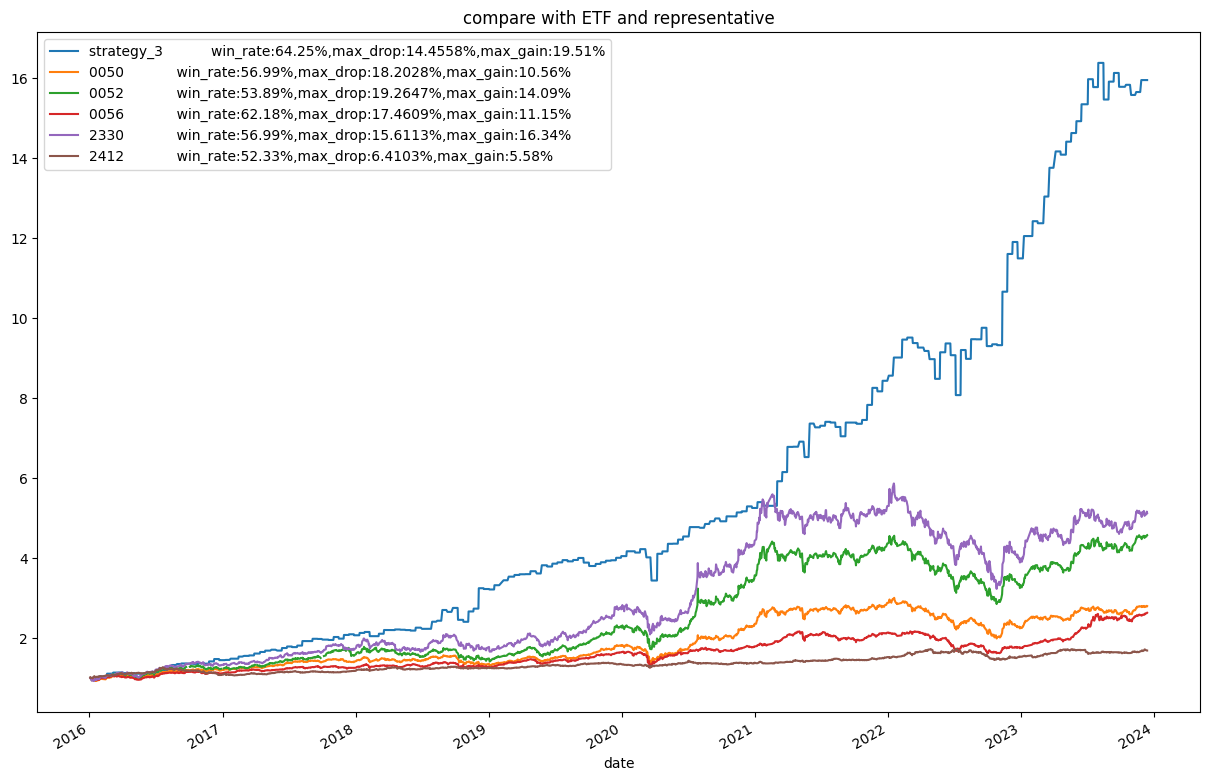

In [1112]:
best_3_count = best_3.shift(1).fillna(1)
s0050 = data.get_adj("開盤價")['0050']['2016':]
s0050 = s0050/s0050[0]
s0056 = data.get_adj("開盤價")['0056']['2016':]
s0056 = s0056/s0056[0]
s0052 = data.get_adj("開盤價")['0052']['2016':]
s0052 = s0052/s0052[0]

s2330 = data.get_adj("開盤價")['2330']['2016':]
s2330 = s2330/s2330[0]

s2412 = data.get_adj("開盤價")['2412']['2016':]
s2412 = s2412/s2412[0]

s0050_ = ((s0050 / s0050.shift(1)).fillna(1)).resample('M').apply(lambda x: x.cumprod().iloc[-1])
s0052_ = ((s0052 / s0052.shift(1)).fillna(1)).resample('M').apply(lambda x: x.cumprod().iloc[-1])
s0056_ = ((s0056 / s0056.shift(1)).fillna(1)).resample('M').apply(lambda x: x.cumprod().iloc[-1])
s2330_ = ((s2330 / s2330.shift(1)).fillna(1)).resample('M').apply(lambda x: x.cumprod().iloc[-1])
s2412_ = ((s2412 / s2412.shift(1)).fillna(1)).resample('M').apply(lambda x: x.cumprod().iloc[-1])

s0050r = s0050.reindex(best_3_count.index)
s0052r = s0052.reindex(best_3_count.index)
s0056r = s0056.reindex(best_3_count.index)
s2330r = s2330.reindex(best_3_count.index)
s2412r = s2412.reindex(best_3_count.index)


pdtitle = 'compare with ETF and representative'
pd.DataFrame({'strategy_3           '+str(win_rate(best_3_count)):best_3_count.reindex(s0050.index, method='ffill'),
            '0050            '+str(win_rate(s0050r)):s0050.reindex(s0050.index, method='ffill'),
            '0052            '+str(win_rate(s0052r)):s0052.reindex(s0050.index, method='ffill'),
            '0056            '+str(win_rate(s0056r)):s0056.reindex(s0050.index, method='ffill'),  
            '2330            '+str(win_rate(s2330r)):s2330.reindex(s0050.index, method='ffill'),
            '2412            '+str(win_rate(s2412r)):s2412.reindex(s0050.index, method='ffill'),
                
             }).plot(figsize=(15,10), title=pdtitle) 


In [1118]:
round(s2412r,4)

2016-01-14    1.0192
2016-01-28    1.0293
2016-02-19    1.0595
2016-03-07    1.0696
2016-03-21    1.0949
               ...  
2023-09-27    1.6231
2023-10-16    1.6231
2023-10-30    1.6231
2023-11-13    1.6441
2023-11-27    1.6651
Name: 2412, Length: 193, dtype: float64

In [1131]:
#best_50 = rs
#best_3 = rs
#best_10 = rs4
pd.set_option('display.max_rows', None)